In [1]:
#!pip install --ignore-installed --upgrade tensorflow

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


signs_types = os.listdir('/content/drive/MyDrive/dataset/TrafficDataSet/train')
print (signs_types)  

print("Types of signs found: ", len(signs_types))

['1', '0', '10', '11', '2', '12', '4', '3', '8', '9', '5', '7', '6']
Types of signs found:  13


In [2]:
signs = []

for item in range(13):
  all_signs = os.listdir("/content/drive/MyDrive/dataset/TrafficDataSet/train/" +str(item))
  for sign in all_signs:
    signs.append((item, str("/content/drive/MyDrive/dataset/TrafficDataSet/train/" +str(item)) + '/' + sign))
    #print(signs[:1])

In [3]:
signs_df = pd.DataFrame(data=signs, columns=['signs_type', 'image'])
print(signs_df.head())
print(signs_df.tail())

   signs_type                                              image
0           0  /content/drive/MyDrive/dataset/TrafficDataSet/...
1           0  /content/drive/MyDrive/dataset/TrafficDataSet/...
2           0  /content/drive/MyDrive/dataset/TrafficDataSet/...
3           0  /content/drive/MyDrive/dataset/TrafficDataSet/...
4           0  /content/drive/MyDrive/dataset/TrafficDataSet/...
      signs_type                                              image
6986          12  /content/drive/MyDrive/dataset/TrafficDataSet/...
6987          12  /content/drive/MyDrive/dataset/TrafficDataSet/...
6988          12  /content/drive/MyDrive/dataset/TrafficDataSet/...
6989          12  /content/drive/MyDrive/dataset/TrafficDataSet/...
6990          12  /content/drive/MyDrive/dataset/TrafficDataSet/...


In [4]:
print("Total number of signs in the dataset: ", len(signs_df))

Total number of signs in the dataset:  6991


In [5]:
sign_count = signs_df['signs_type'].value_counts()

print("signs in each category: ")
print(sign_count)

signs in each category: 
1     646
0     640
4     590
8     568
7     552
9     529
12    528
3     514
6     501
10    494
5     490
11    485
2     454
Name: signs_type, dtype: int64


In [6]:
import cv2
path = '/content/drive/MyDrive/dataset/TrafficDataSet/train/'


im_size = 32


images = []
labels = []

for i in signs_types:
    data_path = path + str(i) 
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)  
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [7]:
images = np.array(images)

images.shape

(6991, 32, 32, 3)

In [8]:
images = images.astype('float32') / 255.0

In [9]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder


y=signs_df['signs_type'].values
print(y[:5])

[0 0 0 0 0]


In [10]:
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[ 0  0  0 ... 12 12 12]


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, y = shuffle(images, y, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=415)

#inpect the shape of the training and testing.
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
num_classes = 13
input_shape = (32, 32, 3)

(5592, 32, 32, 3)
(5592,)
(1399, 32, 32, 3)
(1399,)


In [12]:
!pip install tensorflow-addons==0.16.1

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 32  
patch_size = 8  
num_patches = (image_size // patch_size) ** 2  
embedding_dim = 256  
num_blocks = 4  

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 32 X 32 = 1024
Patch size: 8 X 8 = 64 
Patches per image: 16
Elements per patch (3 channels): 192


In [14]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size, num_patches)(augmented)
    
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    
    x = blocks(x)
    
    representation = layers.GlobalAveragePooling1D()(x)
    representation = layers.Dropout(rate=dropout_rate)(representation)
    logits = layers.Dense(num_classes)(representation)
    
    return keras.Model(inputs=inputs, outputs=logits)

In [15]:
def run_experiment(model):
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
    )
#MODEL TEST
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    
    return history

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [19]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        
        x = self.normalize(inputs)
        
        x_channels = tf.linalg.matrix_transpose(x)
        
        mlp1_outputs = self.mlp1(x_channels)
        
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        
        x = mlp1_outputs + inputs
        
        x_patches = self.normalize(x)
        
        mlp2_outputs = self.mlp2(x_patches)
        
        x = x + mlp2_outputs
        return x

In [20]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/50
35/35 [==============================] - 30s 352ms/step - loss: 2.5853 - acc: 0.1999 - top5-acc: 0.5779 - val_loss: 2.0201 - val_acc: 0.3244 - val_top5-acc: 0.7444 - lr: 0.0050
Epoch 2/50
35/35 [==============================] - 9s 257ms/step - loss: 1.9091 - acc: 0.3713 - top5-acc: 0.7722 - val_loss: 1.6222 - val_acc: 0.4736 - val_top5-acc: 0.8374 - lr: 0.0050
Epoch 3/50
35/35 [==============================] - 9s 263ms/step - loss: 1.6622 - acc: 0.4541 - top5-acc: 0.8296 - val_loss: 1.4693 - val_acc: 0.5121 - val_top5-acc: 0.8776 - lr: 0.0050
Epoch 4/50
35/35 [==============================] - 9s 256ms/step - loss: 1.4981 - acc: 0.5070 - top5-acc: 0.8683 - val_loss: 1.2909 - val_acc: 0.5782 - val_top5-acc: 0.9026 - lr: 0.0050
Epoch 5/50
35/35 [==============================] - 9s 259ms/step - loss: 1.3949 - acc: 0.5370 - top5-acc: 0.8867 - val_loss: 1.2737 - val_acc: 0.5719 - val_top5-acc: 0.9008 - lr: 0.0050
Epoch 6/50
35/35 [==============================] - 9s 260ms/ste

In [21]:
import matplotlib.pyplot as plt


def visualize_history(hist):

    
    histo = hist.history

    plt.style.use('default')
    plt.style.use('seaborn')

    plt.figure(0)
    plt.plot(histo['acc'], label='train accuracy')
    plt.plot(histo['val_acc'], label='val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('train_accuracy')

    plt.figure(1)
    plt.plot(histo['loss'], label='train loss')
    plt.plot(histo['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('train_loss')

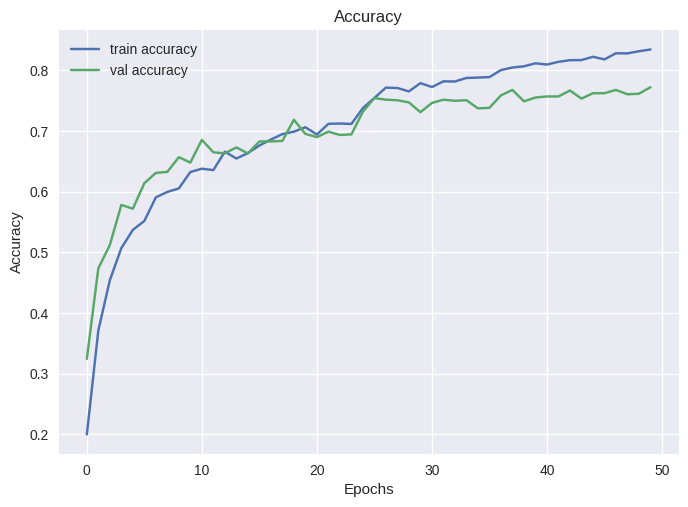

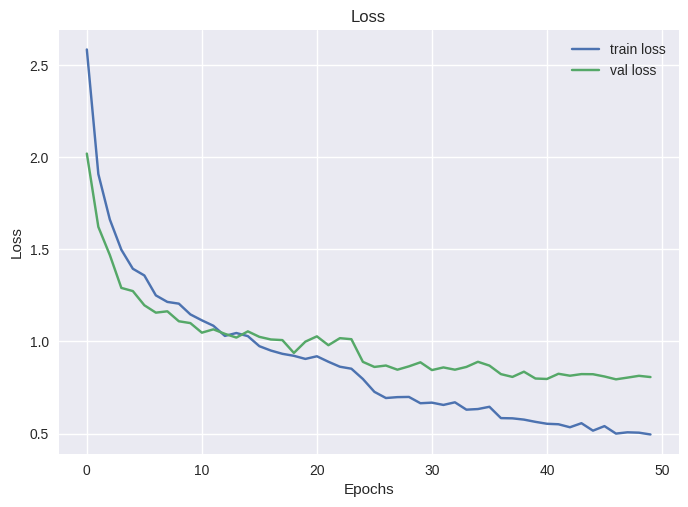

In [22]:
visualize_history(history)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
prep_data_dir="/content/drive/MyDrive/dataset/TrafficDataSet/processed_data/32"

lr=LinearRegression()
lr.fit(x_train,y_train)
print("R score:{0}".format(round(lr.score(x_train,y_train),2)))


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y_test,lr.predict(x_test.reshape((x_test.shape[0], 32*32*3))),color='r')
plt.show()